In [10]:
import os
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from collections import defaultdict
import random

In [5]:
# Paths
images_dir = "data/train/images"
labels_dir = "data/train/labels"

# Class mapping
class_map = {
    0: 'dog',
    1: 'cat',
    2: 'cow',
    3: 'goat',
    4: 'boar',
    5: 'deer',
    6: 'leopard'
}

In [6]:
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

print(f'Total images: {len(image_files)}')
print(f'Total label files: {len(label_files)}')

Total images: 513
Total label files: 513


dog - 78
cat - 74
cow - 594
goat - 162
boar - 102
deer - 174
leopard - 74


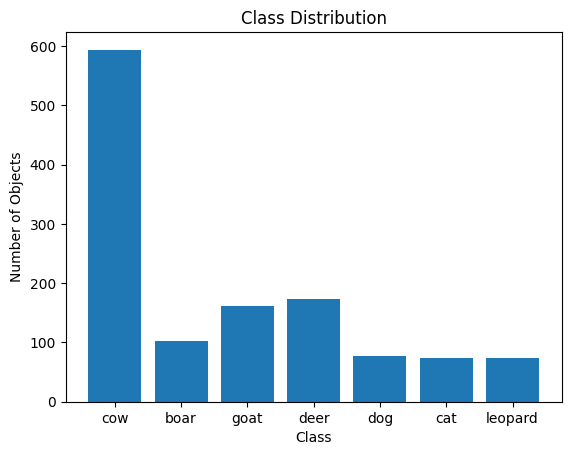

In [7]:
all_classes = []
for label_file in label_files:
    if label_file != "classes.txt":
        with open(os.path.join(labels_dir, label_file)) as f:
            for line in f:
                class_idx = int(line.split()[0])
                all_classes.append(class_idx)

class_counts = Counter(all_classes)

#print all object counts
for class_idx in sorted(class_counts):
    class_name = class_map.get(class_idx, str(class_idx))
    print(f"{class_name} - {class_counts[class_idx]}")

#plot object counts 
plt.bar([class_map[c] for c in class_counts.keys()], class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Objects')
plt.show()

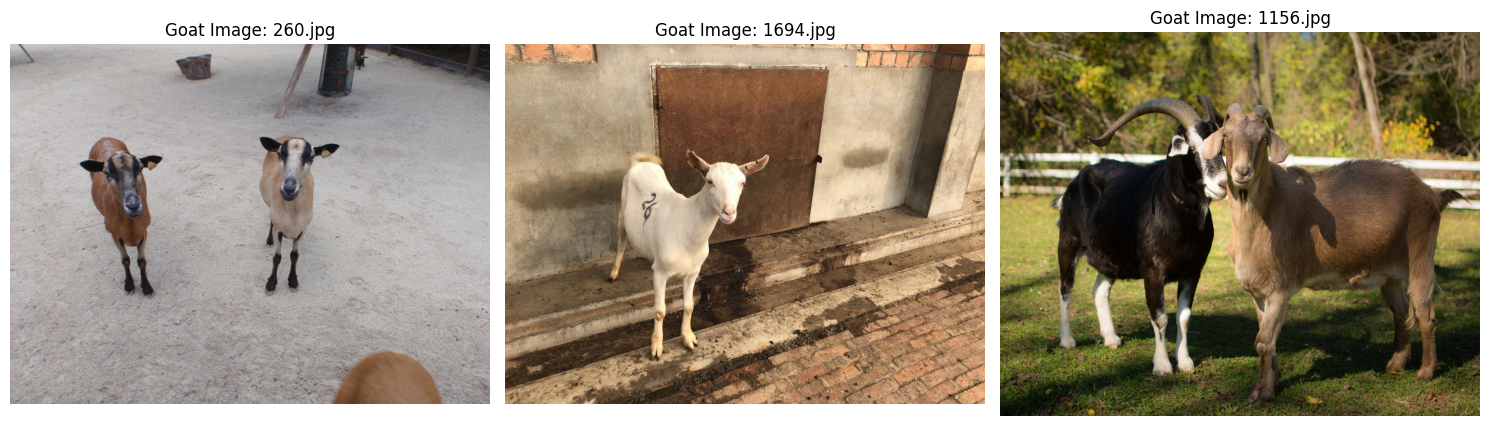

In [24]:
NUM_IMAGES = 3 
TARGET_CLASS = 3   # 3 is target class for goat
def get_goat_images():
    """Identify images containing goats"""
    goat_images = []
    for img_file in os.listdir(images_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            base_name = os.path.splitext(img_file)[0]
            label_path = os.path.join(labels_dir, f"{base_name}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        if line.strip() and int(line.split()[0]) == TARGET_CLASS:
                            goat_images.append(img_file)
                            break
    return goat_images

def display_images(image_paths):
    """Display images in a grid"""
    plt.figure(figsize=(15, 10))
    class_name = class_map.get(TARGET_CLASS, 'Unknown')
    for i, img_path in enumerate(image_paths, 1):
        img = cv2.imread(os.path.join(images_dir, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, len(image_paths), i)
        plt.imshow(img_rgb)
        plt.title(f"{class_name.capitalize()} Image: {img_path}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main execution
goat_images = get_goat_images()
selected_images = random.sample(goat_images, min(NUM_IMAGES, len(goat_images)))

if selected_images:
    #print(f"Displaying {len(selected_images)} goat images:")
    display_images(selected_images)
else:
    print("No goat images found in the dataset")

Displaying 3images with large bounding boxes (>0.7 normalized size):


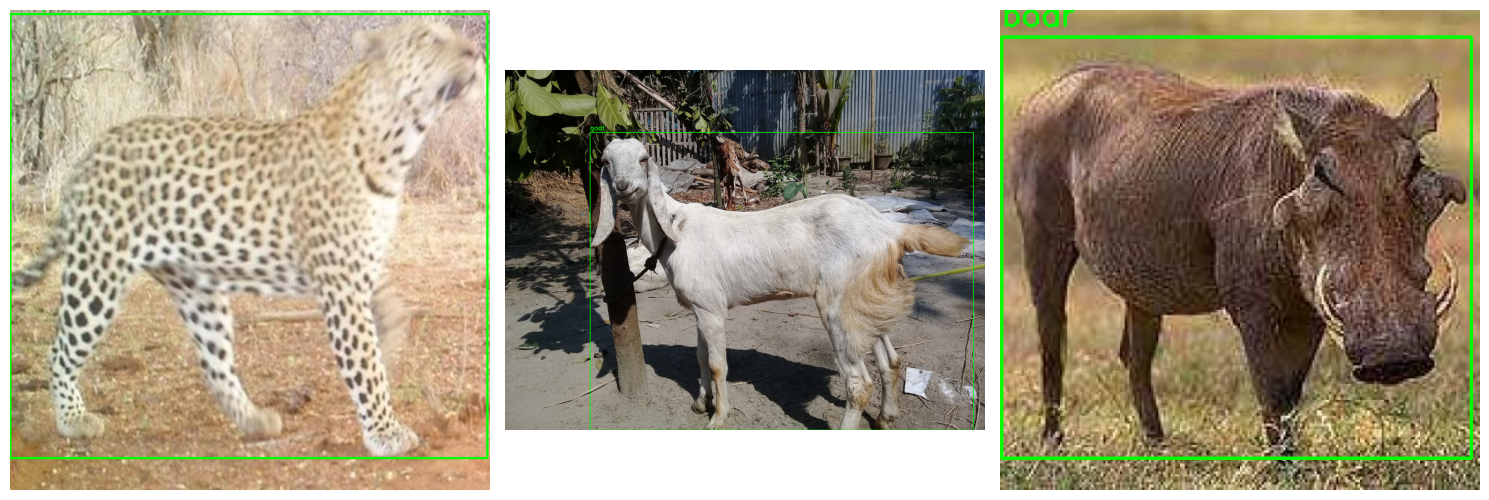

In [50]:
# Configuration
THRESHOLD = 0.7  # Normalized size threshold for width/height
NUM_IMAGES = 3   # Number of images to display

def get_large_bbox_images(threshold):
    """Find images with bounding boxes larger than threshold"""
    large_bbox_images = []
    for img_file in os.listdir(images_dir):
        if img_file.lower().endswith(('.jpg', '.png')):
            base_name = os.path.splitext(img_file)[0]
            label_path = os.path.join(labels_dir, f"{base_name}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            parts = line.split()
                            if len(parts) == 5:  # YOLO format: class x_center y_center width height
                                w = float(parts[3])
                                h = float(parts[4])
                                if w > threshold and h > threshold:
                                    large_bbox_images.append(img_file)
                                    break
    return large_bbox_images

def draw_boxes(image, label_path):
    """Draw bounding boxes and class labels on image"""
    h, w = image.shape[:2]
    with open(label_path, 'r') as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * w
                    y_center = float(parts[2]) * h
                    box_w = float(parts[3]) * w
                    box_h = float(parts[4]) * h
                    
                    # Calculate coordinates
                    x1 = int(x_center - box_w/2)
                    y1 = int(y_center - box_h/2)
                    x2 = int(x_center + box_w/2)
                    y2 = int(y_center + box_h/2)
                    
                    # Draw rectangle
                    color = (0, 255, 0)  # Green
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                    
                    # Draw class label
                    class_name = class_map.get(class_id, 'unknown')
                    cv2.putText(image, class_name, (x1, y1-10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

def display_images_withbb(image_paths):
    """Display images with bounding boxes"""
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths, 1):
        img = cv2.imread(os.path.join(images_dir, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get corresponding label path
        base_name = os.path.splitext(img_path)[0]
        label_path = os.path.join(labels_dir, f"{base_name}.txt")
        
        # Draw bounding boxes
        draw_boxes(img_rgb, label_path)
        
        plt.subplot(1, len(image_paths), i)
        plt.imshow(img_rgb)
        #plt.title(f"Image: {img_path}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main execution
large_bbox_images = get_large_bbox_images(THRESHOLD)
selected_images = random.sample(large_bbox_images, min(NUM_IMAGES, len(large_bbox_images)))

if selected_images:
    print(f"Displaying {len(selected_images)}images with large bounding boxes (>{THRESHOLD} normalized size):")
    display_images_withbb(selected_images)
else:
    print(f"No images found with bounding boxes larger than {THRESHOLD} in normalized size")

Displaying 3 images with more than 4 objects:


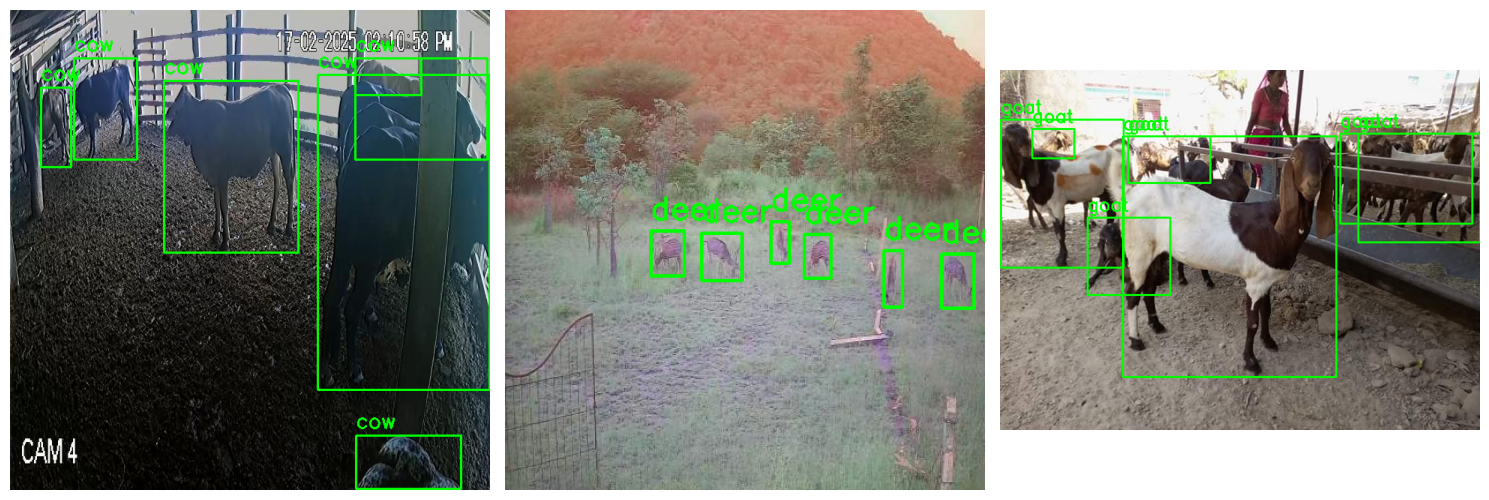

In [57]:
MIN_OBJECTS = 5
NUM_IMAGES = 3

def get_crowded_images(min_objects):
    """Find images with more than min_objects"""
    crowded_images = []
    for img_file in os.listdir(images_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            base_name = os.path.splitext(img_file)[0]
            label_path = os.path.join(labels_dir, f"{base_name}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    num_objects = sum(1 for line in f if line.strip())
                if num_objects > min_objects:
                    crowded_images.append(img_file)
    return crowded_images

# Main execution
crowded_images = get_crowded_images(MIN_OBJECTS - 1)  # MIN_OBJECTS-1 because we want >4
selected_images = random.sample(crowded_images, min(NUM_IMAGES, len(crowded_images)))

if selected_images:
    print(f"Displaying {len(selected_images)} images with more than {MIN_OBJECTS-1} objects:")
    display_images_withbb(selected_images)
else:
    print(f"No images found with more than {MIN_OBJECTS-1} objects")

In [59]:
# Helper functions for conditions
def has_class(class_labels, target_class):
    return target_class in class_labels

def has_big_bbox(bboxes, threshold=0.5):
    # YOLO bbox: [x_center, y_center, width, height], all normalized [0,1]
    for bbox in bboxes:
        if bbox[2] > threshold or bbox[3] > threshold:
            return True
    return False

def has_many_objects(class_labels, max_objects=5):
    return len(class_labels) >= max_objects

# Build conditional augmentation pipeline
def get_transform(class_labels, bboxes):
    transforms = []
    # More noise for goats (class 3) and boars (class 4)
    if has_class(class_labels, 3) or has_class(class_labels, 4):
        transforms.append(A.GaussNoise(var_limit=(30.0, 60.0), p=0.5))
        transforms.append(A.RandomBrightnessContrast(brightness_limit=(-0.50, 0.50), contrast_limit=(-0.3, 0.3), p=0.5))
        transforms.append(A.ImageCompression(quality_lower=20, quality_upper=80, p=0.7))
        transforms.append(A.Blur(blur_limit=5, p=0.15))
    else:
        transforms.append(A.GaussNoise(var_limit=(5.0, 20.0), p=0.3))
        transforms.append(A.RandomBrightnessContrast(brightness_limit=(-0.25, 0.25), contrast_limit=(-0.1, 0.1), p=0.3))
        transforms.append(A.ImageCompression(quality_lower=60, quality_upper=100, p=0.2))
    # Crop only if no big bbox
    if not has_big_bbox(bboxes):
        transforms.append(A.RandomResizedCrop(height=416, width=416, scale=(0.8, 1.0), p=0.2))
        transforms.append(A.ImageCompression(quality_lower=40, quality_upper=80, p=0.5))

    # Flip only if not too many objects
    if not has_many_objects(class_labels):
        transforms.append(A.HorizontalFlip(p=0.5))
    # Other photometric transforms
    transforms.extend([
        A.CLAHE(p=0.05),
        A.RandomGamma(p=0.05),
        A.Blur(blur_limit=3, p=0.05),
        A.MedianBlur(blur_limit=3, p=0.05),
    ])
    return A.Compose(
        transforms,
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
    )

# Read YOLO labels
def read_yolo_labels(label_path):
    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                bboxes.append([x_center, y_center, width, height])
                class_labels.append(cls)
    return bboxes, class_labels

# Save YOLO labels
def save_yolo_labels(label_path, bboxes, class_labels):
    with open(label_path, 'w') as f:
        for bbox, cls in zip(bboxes, class_labels):
            line = f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n"
            f.write(line)

# Main augmentation loop
def augment_dataset(
    image_folder, label_folder, output_image_folder, output_label_folder, num_aug_per_image=5
):
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_label_folder, exist_ok=True)
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        label_path = os.path.join(label_folder, os.path.splitext(img_file)[0] + '.txt')
        image = cv2.imread(img_path)
        bboxes, class_labels = read_yolo_labels(label_path)
        for i in range(num_aug_per_image):
            transform = get_transform(class_labels, bboxes)
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']
            out_img_path = os.path.join(output_image_folder, f"{os.path.splitext(img_file)[0]}_aug_{i}.jpg")
            out_label_path = os.path.join(output_label_folder, f"{os.path.splitext(img_file)[0]}_aug_{i}.txt")
            cv2.imwrite(out_img_path, aug_image)
            save_yolo_labels(out_label_path, aug_bboxes, aug_class_labels)

# Example usage:
# augment_dataset('input_images', 'input_labels', 'aug_images', 'aug_labels', num_aug_per_image=5)